In [1]:
%matplotlib inline
import os
import re
import io

import matplotlib
import numpy as np
import pandas as pd
import xarray as xr

import climatools.html.html as climahtml
import climatools.lblnew.g1_threshold as scripts

import IPython.display as display

import imp
imp.reload(scripts)

/chia_cluster/home/jackyu/anaconda3/lib/python3.6/site-packages/matplotlib/__init__.py:1405: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

  warnings.warn(_use_error_msg)


<module 'climatools.lblnew.g1_threshold' from '/chia_cluster/home/jackyu/climatools/climatools/lblnew/g1_threshold.py'>

In [2]:
%run param.py

In [3]:
NG_REFS = PARAM['ng_refs']
P_REFS, T_REFS = zip(*PARAM['ref_pts'])

The history saving thread hit an unexpected error (OperationalError('database is locked',)).History will not be written to the database.


In [4]:
# for printing some input parameters

def innames():
    return ['vstar', 'nband', 'nv', 'dv',
            'flgh2o',
            'tsfc',
            'pressure_reference_1',
            'temperature_reference_1', 
            'pressure_reference_2', 
            'temperature_reference_2',
            'ighigh', 
            'ng', 
            'nref',
            'p_refs',
            't_refs',
            'ng_refs',
            'ng_adju',
            'absth',
            'wgt',
            'option_wgt_flux',
            'option_wgt_k',
            'option_klin',
            'w_diffuse',
            'fac_meank',
            'klin',
            'option_compute_ktable',
            'option_compute_btable',
            'conc']



def pattern_assign(name):
    return ''' 
    parameter .* :: \s* &? \s* ({} \s* = .* \n)
    '''.format(name)

def pattern_data(name):
    return '''
    (data [^/{name}]+ {name}[^,] [^/{name}]+ / [^/]+ /)
    '''.format(name=name)

def pattern_atmpro():
    return '''
    (atmosphere_profiles/.*75_r8.pro)
    '''
    

def get_input_params(code, names):
    results = []
    for name in names:
        regex = re.compile(pattern_assign(name), re.VERBOSE)
        results.extend(regex.findall(code))
        
        regex = re.compile(pattern_data(name), re.VERBOSE)
        results.extend(regex.findall(code))
        
    regex = re.compile(pattern_atmpro(), re.VERBOSE)
    results.extend(regex.findall(code))
        
    results = [result.replace('_r8', '') for result in results]
    return results


In [5]:
analysis = scripts.Analysis()

In [6]:
crd = analysis.model('crd')
crd.type_model = 'crd'
crd.rundir = DIR_FORTRAN
crd.fpath_flux = 'output_fluxg.dat'
crd.fpath_coolr = 'output_coolrg.dat'
crd.linestyle = '-'
crd.color = 'b'
crd.marker = None
crd.load_data()

In [7]:
def add_wgt_models():
    iggs = [10, 1]
    markers = [None, 'x']
    colors = ['r', 'c']
    linestyle = '-'

    df_wfluxg = pd.read_csv(os.path.join(crd.rundir, 
                                         'output_wfluxg.dat'), 
                            sep=r'\s+')

    df_wcoolrg = pd.read_csv(os.path.join(crd.rundir, 
                                          'output_wcoolrg.dat'), 
                             sep=r'\s+')

    for igg, marker, color in zip(iggs, markers, colors):

        flux_igg = df_wfluxg[df_wfluxg['igg'] == igg]\
        .drop('igg', axis=1)
        s_flux = io.StringIO(flux_igg.to_csv(sep=' '))

        coolr_igg = df_wcoolrg[df_wcoolrg['igg'] == igg]\
        .drop('igg', axis=1)
        s_coolr = io.StringIO(coolr_igg.to_csv(sep=' '))

        crdx_igg = analysis.model('wgt_igg{}'.format(igg))
        crdx_igg.type_model = 'crd'
        crdx_igg.rundir = DIR_FORTRAN
        crdx_igg.fpath_flux = s_flux
        crdx_igg.fpath_coolr = s_coolr
        crdx_igg.color = color
        crdx_igg.marker = marker
        crdx_igg.linestyle = linestyle
        crdx_igg.load_data()
        
add_wgt_models()

In [8]:
def add_ktable_models():
    iggs = [10]
    markers = ['D',]
    color = 'g'
    linestyle = ':'

    df_wwfluxg = pd.read_csv(os.path.join(crd.rundir, 
                                          'output_wwfluxg.dat'), 
                             sep=r'\s+')

    df_wwcoolrg = pd.read_csv(os.path.join(crd.rundir, 
                                           'output_wwcoolrg.dat'), 
                              sep=r'\s+')

    for igg, marker in zip(iggs, markers):

        flux_igg = df_wwfluxg[df_wwfluxg['igg'] == igg]\
        .drop('igg', axis=1)
        s_flux = io.StringIO(flux_igg.to_csv(sep=' '))

        coolr_igg = df_wwcoolrg[df_wwcoolrg['igg'] == igg]\
        .drop('igg', axis=1)
        s_coolr = io.StringIO(coolr_igg.to_csv(sep=' '))

        crdxx_igg = analysis.model('ktable_igg{}'.format(igg))
        crdxx_igg.type_model = 'crd'
        crdxx_igg.rundir = DIR_FORTRAN
        crdxx_igg.fpath_flux = s_flux
        crdxx_igg.fpath_coolr = s_coolr
        crdxx_igg.color = color
        crdxx_igg.marker = marker
        crdxx_igg.linestyle = linestyle
        crdxx_igg.load_data()
        
        

In [9]:
fig = analysis.fig_fluxcoolr('fig1', vartypes=['cooling rate'])
fig.ggroups = list(crd.data['dgdgs'].coords['g'].values) #list(range(1, 8 + 1))
fig.vars_plot['flux'] = ['flug', 'fnetg']
fig.vars_plot['cooling rate'] = ['coolrg']
fig.colors['flug'] = 'darkred'
fig.colors['fnetg'] = 'lightcoral'
fig.colors['coolrg'] = 'blue'
fig.varlims_from_indexrange['linear'] = (50, 1050)
fig.varlims_from_indexrange['log'] = (1e-2, 200)

fig.set_pressure_displayrange(low=1e-2)

In [10]:
table_fluxg = analysis.table('table_fluxg')
table_fluxg.sumg = False
table_fluxg.vartype = 'flux'
table_fluxg.at_pressures = crd.data['flux']\
                             .coords['pressure']\
                             .isel(pressure=[0, -1])

table_coolrg = analysis.table('table_coolrg')
table_coolrg.vartype = 'cooling rate'
table_coolrg.sumg = False
table_coolrg.at_pressures = crd.data['cooling rate']\
                               .coords['pressure']\
                               .isel(pressure=[0, -1])


In [11]:
table_flux = analysis.table('table_flux')
table_flux.sumg = True
table_flux.vartype = 'flux'
table_flux.at_pressures = crd.data['flux']\
                             .coords['pressure']\
                             .isel(pressure=[0, -1])

table_coolr = analysis.table('table_coolr')
table_coolr.vartype = 'cooling rate'
table_coolr.sumg = True
table_coolr.at_pressures = crd.data['cooling rate']\
                              .coords['pressure']\
                              .isel(pressure=[0, -1])

In [12]:
table_dgdgs = analysis.table('dgdgs')
table_dgdgs.vartype = 'dgdgs'
table_dgdgs.sumg = False

In [13]:
for name, value in sorted(PARAM.items()):
    print('{} = {}'.format(name, value))

atmpro = saw
band = 3b
commitnumber = d5931a1
conc = 0.0004
dv = 0.005
klin = 0
molecule = co2
ng_adju = [0, 0]
ng_refs = [5, 2]
nv = 200
option_compute_btable = 0
option_compute_ktable = 0
option_wgt_flux = 1
option_wgt_k = 1
ref_pts = [(1, 250), (10, 250)]
tsfc = 257
vmax = 720
vmin = 620
w_diffuse = [(1.66, 1.66, 1.66, 1.66, 1.66), (1.66, 1.66)]
wgt = [(0, 0.6, 0.5, 0.7, 0.8), (0.8, 0.7)]


In [14]:
fig.display_hrefanchor()

In [15]:
table_fluxg.display_hrefanchor()
table_coolrg.display_hrefanchor()

table_flux.display_hrefanchor()
table_coolr.display_hrefanchor()

In [16]:
table_dgdgs.display_hrefanchor()

In [17]:
s_abscom = 'Overall absth'
display.HTML(climahtml.getHTML_hrefanchor(s_abscom))

In [18]:
s_ggroup_summary = 'g-group summary'
display.HTML(climahtml.getHTML_hrefanchor(s_ggroup_summary))

In [19]:
#for g in range(1, 20 + 1):
#    s = 'Table: cooling rate. g-group {}'.format(g)
#    html = climahtml.getHTML_hrefanchor(s)
#    display.display(display.HTML(html))

# Figure: cooling rate g-group 1

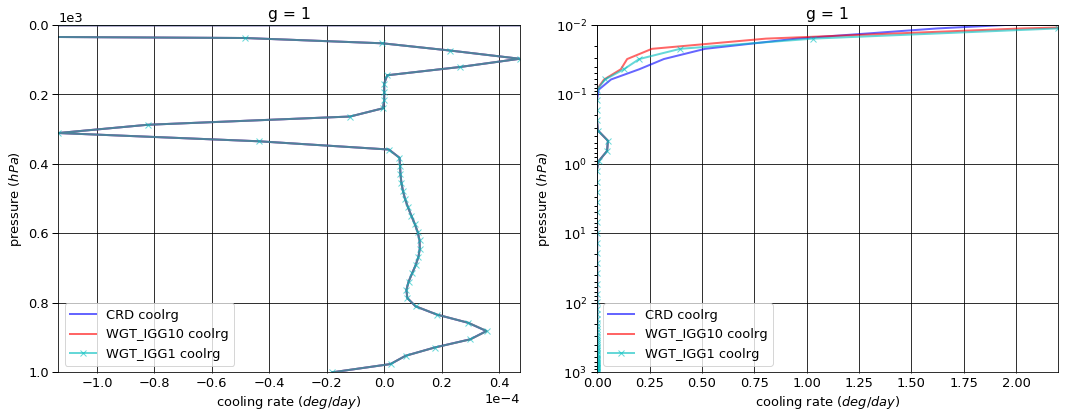

# Figure: cooling rate g-group 2

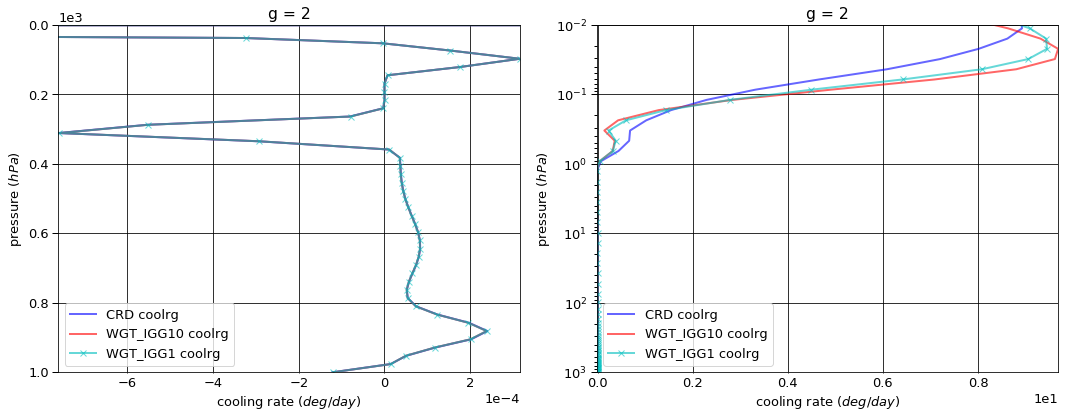

# Figure: cooling rate g-group 3

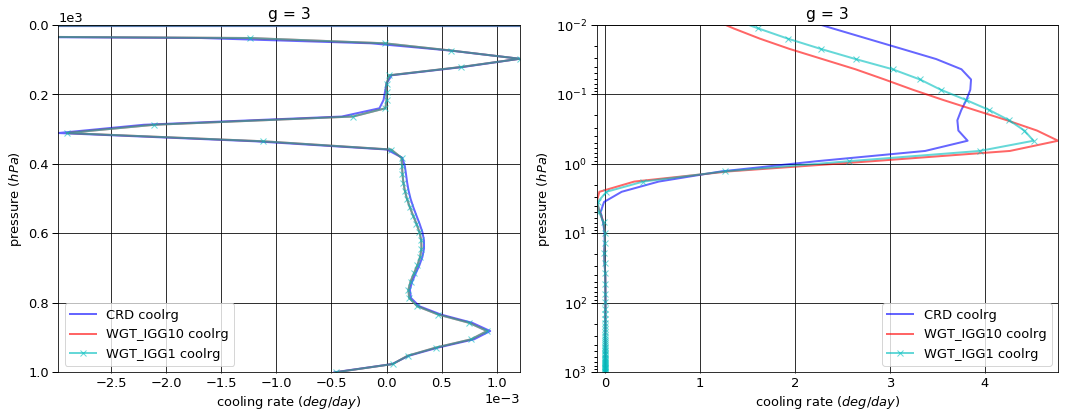

# Figure: cooling rate g-group 4

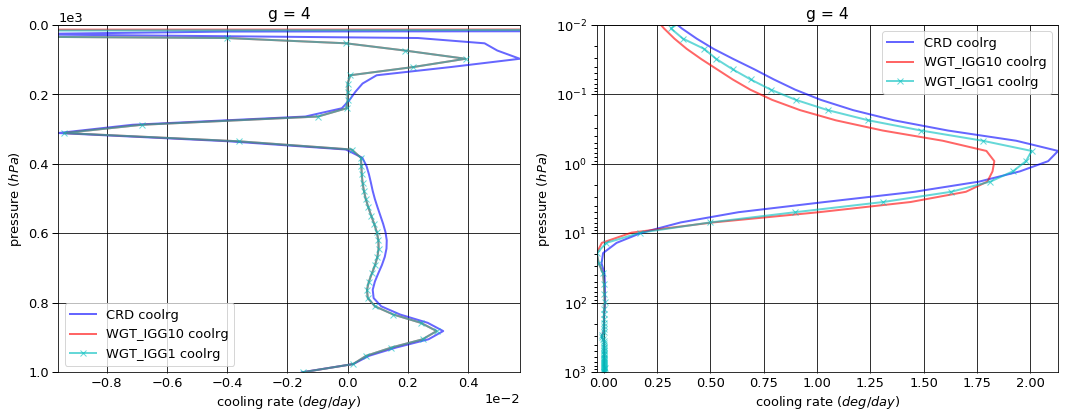

# Figure: cooling rate g-group 5

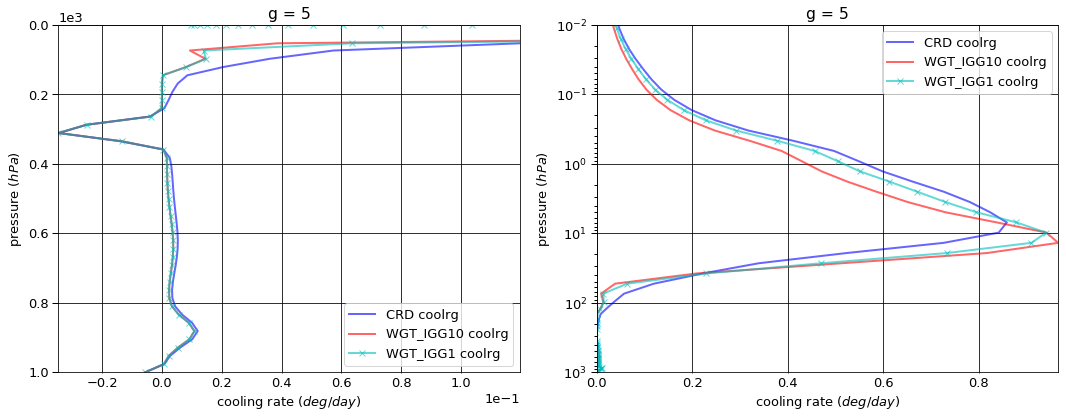

# Figure: cooling rate g-group 6

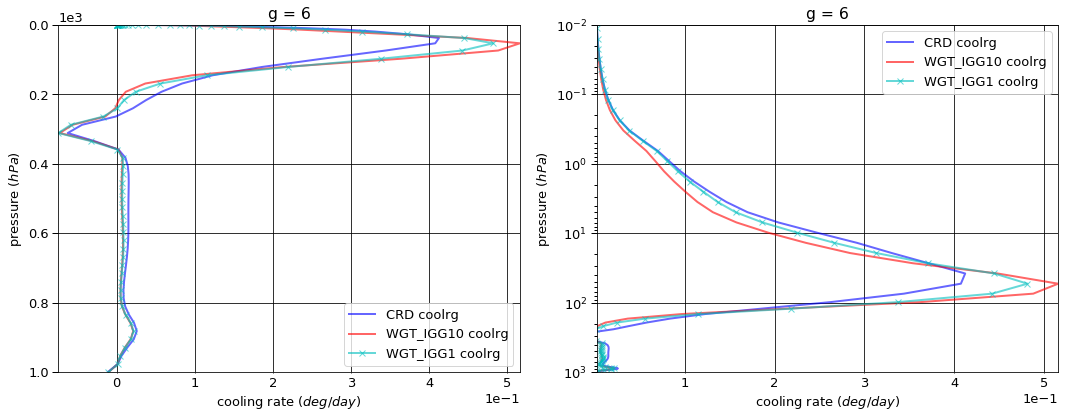

# Figure: cooling rate g-group 7

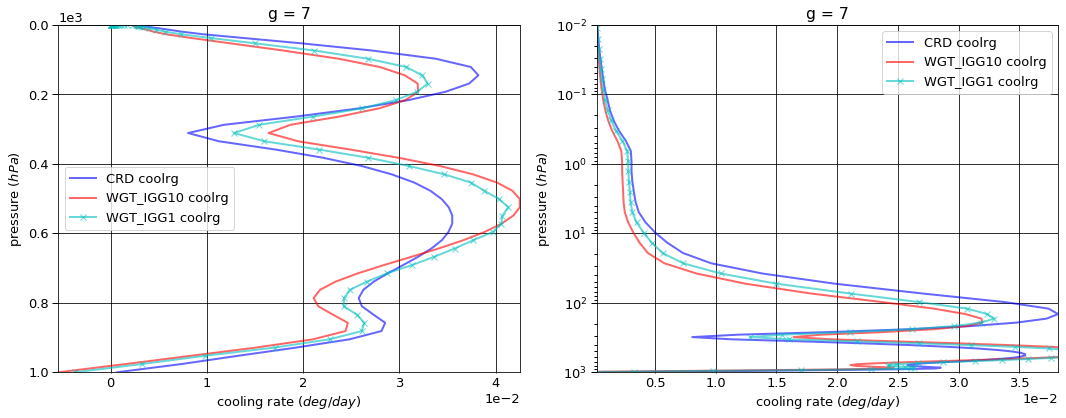

# Figure: cooling rate g-group total

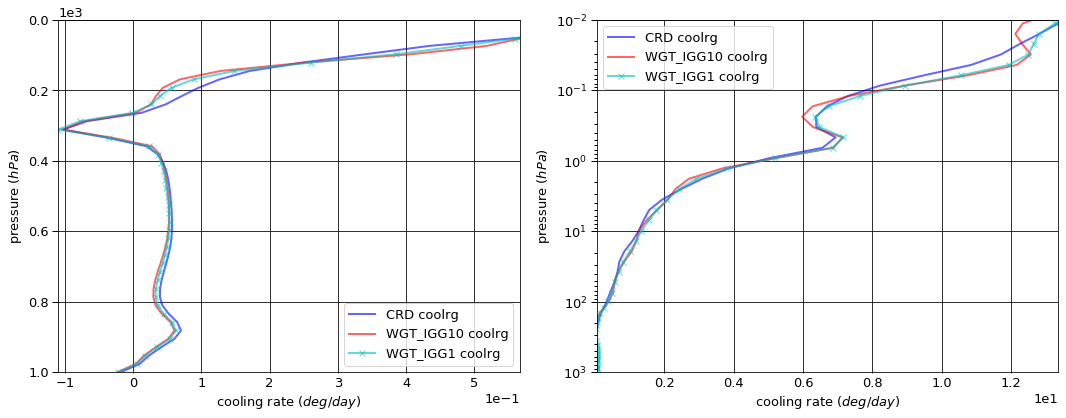

In [20]:
matplotlib.rcParams.update({'font.size': 13,
                            'grid.color': 'black',
                            'axes.facecolor': 'white',
                            'axes.edgecolor': 'black',
                            'ytick.direction': 'out',
                            'ytick.major.size': 6, 'ytick.major.width': 1,
                            'ytick.minor.size': 3, 'ytick.minor.width': 1,
                            'xtick.direction': 'out',
                            'xtick.major.size': 6, 'xtick.major.size': 1,
                            'xtick.minor.size': 3, 'xtick.minor.size': 1}) 

fig.plot(analysis)


In [21]:
table_fluxg.display_withdiff(analysis, benchmark='crd')
table_coolrg.display_withdiff(analysis, benchmark='crd')
table_flux.display_withdiff(analysis, benchmark='crd')
table_coolr.display_withdiff(analysis, benchmark='crd')

# Table: flux. g-groups 


CRD


flug       fldg     fnetg
g pressure level                                
1 0.0      1      -0.011666   0.000000 -0.011666
  1013.0   76     -0.021720   0.021836  0.000116
2 0.0      1      -0.120060   0.000000 -0.120060
  1013.0   76     -0.145122   0.145905  0.000783
3 0.0      1      -0.487783   0.000000 -0.487783
  1013.0   76     -0.556353   0.559432  0.003079
4 0.0      1      -1.118784   0.000000 -1.118784
  1013.0   76     -1.801406   1.811323  0.009917
5 0.0      1      -3.250366   0.000000 -3.250366
  1013.0   76     -6.636364   6.672751  0.036387
6 0.0      1      -6.176183   0.000000 -6.176183
  1013.0   76    -12.730956  12.806751  0.075795
7 0.0      1      -3.132965   0.000000 -3.132965
  1013.0   76     -5.145298   5.097168 -0.048130


WGT_IGG10


flug       fldg     fnetg
g pressure level                                
1 0.0      1      -0.011943   0.000000 -0.011943
  1013.0   76     -0.021725   0.021841  0.000116
2 0.0      1      -0.117295   0.000000 -0.117295
  1013.0   76     -0.145149   0.145926  0.000777
3 0.0      1      -0.511130   0.000000 -0.511130
  1013.0   76     -0.556480   0.559458  0.002978
4 0.0      1      -1.130654   0.000000 -1.130654
  1013.0   76     -1.801947   1.811591  0.009644
5 0.0      1      -3.177791   0.000000 -3.177791
  1013.0   76     -6.637711   6.673234  0.035524
6 0.0      1      -6.089423   0.000000 -6.089423
  1013.0   76    -12.731437  12.799974  0.068537
7 0.0      1      -3.005200   0.000000 -3.005200
  1013.0   76     -5.142771   5.211773  0.069002


WGT_IGG1


flug       fldg     fnetg
g pressure level                                
1 0.0      1      -0.012010   0.000000 -0.012010
  1013.0   76     -0.021725   0.021841  0.000116
2 0.0      1      -0.117255   0.000000 -0.117255
  1013.0   76     -0.145149   0.145926  0.000777
3 0.0      1      -0.505456   0.000000 -0.505456
  1013.0   76     -0.556480   0.559458  0.002978
4 0.0      1      -1.134894   0.000000 -1.134894
  1013.0   76     -1.801947   1.811591  0.009644
5 0.0      1      -3.196033   0.000000 -3.196033
  1013.0   76     -6.637711   6.673234  0.035524
6 0.0      1      -6.095625   0.000000 -6.095625
  1013.0   76    -12.731437  12.800773  0.069336
7 0.0      1      -3.058680   0.000000 -3.058680
  1013.0   76     -5.142771   5.203178  0.060408


WGT_IGG10 - CRD


flug      fldg         fnetg
g pressure level                                  
1 0.0      1     -0.000277  0.000000 -2.772000e-04
  1013.0   76    -0.000005  0.000005  2.573800e-07
2 0.0      1      0.002765  0.000000  2.765020e-03
  1013.0   76    -0.000026  0.000020 -6.075060e-06
3 0.0      1     -0.023346  0.000000 -2.334646e-02
  1013.0   76    -0.000127  0.000026 -1.007459e-04
4 0.0      1     -0.011870  0.000000 -1.187000e-02
  1013.0   76    -0.000541  0.000268 -2.732844e-04
5 0.0      1      0.072574  0.000000  7.257440e-02
  1013.0   76    -0.001347  0.000484 -8.633610e-04
6 0.0      1      0.086760  0.000000  8.675980e-02
  1013.0   76    -0.000481 -0.006777 -7.258649e-03
7 0.0      1      0.127765  0.000000  1.277653e-01
  1013.0   76     0.002527  0.114605  1.171322e-01


WGT_IGG1 - CRD


flug      fldg         fnetg
g pressure level                                  
1 0.0      1     -0.000344  0.000000 -3.441310e-04
  1013.0   76    -0.000005  0.000005  2.573800e-07
2 0.0      1      0.002805  0.000000  2.804910e-03
  1013.0   76    -0.000026  0.000020 -6.075060e-06
3 0.0      1     -0.017673  0.000000 -1.767257e-02
  1013.0   76    -0.000127  0.000026 -1.007459e-04
4 0.0      1     -0.016110  0.000000 -1.611010e-02
  1013.0   76    -0.000541  0.000268 -2.732844e-04
5 0.0      1      0.054332  0.000000  5.433230e-02
  1013.0   76    -0.001347  0.000484 -8.633610e-04
6 0.0      1      0.080558  0.000000  8.055760e-02
  1013.0   76    -0.000481 -0.005978 -6.459316e-03
7 0.0      1      0.074285  0.000000  7.428510e-02
  1013.0   76     0.002527  0.106011  1.085379e-01

# Table: cooling rate. g-groups 


CRD


coolrg
g pressure    layer           
1 0.000312    1      32.726323
  1001.112500 75     -0.000018
2 0.000312    1       3.366569
  1001.112500 75     -0.000122
3 0.000312    1       0.046949
  1001.112500 75     -0.000475
4 0.000312    1       0.051555
  1001.112500 75     -0.001526
5 0.000312    1       0.010235
  1001.112500 75     -0.005629
6 0.000312    1       0.000331
  1001.112500 75     -0.011694
7 0.000312    1       0.000033
  1001.112500 75      0.000659


WGT_IGG10


coolrg
g pressure    layer           
1 0.000312    1      13.947816
  1001.112500 75     -0.000018
2 0.000312    1       0.938352
  1001.112500 75     -0.000120
3 0.000312    1      -0.090493
  1001.112500 75     -0.000462
4 0.000312    1       0.057600
  1001.112500 75     -0.001495
5 0.000312    1       0.008485
  1001.112500 75     -0.005508
6 0.000312    1       0.000282
  1001.112500 75     -0.010671
7 0.000312    1       0.000025
  1001.112500 75     -0.005419


WGT_IGG1


coolrg
g pressure    layer           
1 0.000312    1      15.925797
  1001.112500 75     -0.000018
2 0.000312    1       1.790149
  1001.112500 75     -0.000120
3 0.000312    1      -0.060579
  1001.112500 75     -0.000462
4 0.000312    1       0.053753
  1001.112500 75     -0.001495
5 0.000312    1       0.009589
  1001.112500 75     -0.005508
6 0.000312    1       0.000339
  1001.112500 75     -0.010876
7 0.000312    1       0.000032
  1001.112500 75     -0.003720


WGT_IGG10 - CRD


coolrg
g pressure    layer              
1 0.000312    1     -1.877851e+01
  1001.112500 75    -4.110300e-08
2 0.000312    1     -2.428217e+00
  1001.112500 75     1.214420e-06
3 0.000312    1     -1.374428e-01
  1001.112500 75     1.301007e-05
4 0.000312    1      6.044983e-03
  1001.112500 75     3.115500e-05
5 0.000312    1     -1.750308e-03
  1001.112500 75     1.209532e-04
6 0.000312    1     -4.876661e-05
  1001.112500 75     1.022443e-03
7 0.000312    1     -8.648949e-06
  1001.112500 75    -6.077709e-03


WGT_IGG1 - CRD


coolrg
g pressure    layer              
1 0.000312    1     -1.680053e+01
  1001.112500 75    -4.110300e-08
2 0.000312    1     -1.576420e+00
  1001.112500 75     1.214420e-06
3 0.000312    1     -1.075288e-01
  1001.112500 75     1.301007e-05
4 0.000312    1      2.198702e-03
  1001.112500 75     3.115500e-05
5 0.000312    1     -6.463481e-04
  1001.112500 75     1.209532e-04
6 0.000312    1      8.226540e-06
  1001.112500 75     8.180390e-04
7 0.000312    1     -1.409355e-06
  1001.112500 75    -4.378388e-03

# Table: flux. g-groups total


CRD


,,flug,fldg,fnetg
pressure,level,,,
0.0,1,-14.297807,0.000000,-14.297807
1013.0,76,-27.037219,27.115166,0.077947



WGT_IGG10


,,flug,fldg,fnetg
pressure,level,,,
0.0,1,-14.043436,0.000000,-14.043436
1013.0,76,-27.037219,27.223797,0.186577



WGT_IGG1


,,flug,fldg,fnetg
pressure,level,,,
0.0,1,-14.119954,0.000000,-14.119954
1013.0,76,-27.037219,27.216001,0.178782



WGT_IGG10 - CRD


,,flug,fldg,fnetg
pressure,level,,,
0.0,1,2.543709e-01,0.000000,0.254371
1013.0,76,3.260000e-07,0.108631,0.108630



WGT_IGG1 - CRD


,,flug,fldg,fnetg
pressure,level,,,
0.0,1,1.778531e-01,0.000000,0.177853
1013.0,76,3.260000e-07,0.100835,0.100835


# Table: cooling rate. g-groups total


CRD


,,coolrg
pressure,layer,
0.000312,1,36.201996
1001.112500,75,-0.018805



WGT_IGG10


,,coolrg
pressure,layer,
0.000312,1,14.862066
1001.112500,75,-0.023694



WGT_IGG1


,,coolrg
pressure,layer,
0.000312,1,17.719080
1001.112500,75,-0.022199



WGT_IGG10 - CRD


,,coolrg
pressure,layer,
0.000312,1,-21.339930
1001.112500,75,-0.004889



WGT_IGG1 - CRD


,,coolrg
pressure,layer,
0.000312,1,-18.482916
1001.112500,75,-0.003394


In [22]:
table_dgdgs.display_dgdgs(crd)

# Table: dgdgs. g-groups 

,dg,dgs
g,,
1,0.00080,0.000804
2,0.00535,0.005368
3,0.02050,0.020582
4,0.06635,0.066647
5,0.24470,0.245503
6,0.47055,0.470886
7,0.19175,0.190211


In [23]:
# read and display overall absth
display.display(
    display.HTML(climahtml.getHTML_idanchor(s_abscom)))
display.display(
    display.Markdown(climahtml.getMarkdown_sectitle(s_abscom)))

display.display(pd.read_csv(os.path.join(crd.rundir, 'abscom.dat'),
                sep=r'\s+',
                index_col=[0]))

# Overall absth

,abscom
g,
1,1.230874e-17
2,6.648507e-19
3,3.591161e-20
4,1.939749e-21
5,1.047746e-22
6,5.656349e-23
7,3.056898e-24


In [24]:
def spreadsheet(ng_refs, p_refs):
    ng = crd.data['dgdgs'].dims['g']
    
    df_abscom = pd.read_csv(os.path.join(crd.rundir, 'abscom.dat'), 
                            sep=r'\s+', index_col=[0])
    
    # absth(g + 1) / absth(g)
    df_abscom_copy = df_abscom.copy()
    df_abscom_copy.index = df_abscom.index + 1
    df_absratio = df_abscom / df_abscom_copy
    df_absratio.columns = ['k(ig) / k(ig - 1)']
    df_absratio = df_absratio.loc[: ng]
    df_dgdgs = crd.data['dgdgs'].to_dataframe()
    
    
    df_dgdgs_cumsum = df_dgdgs.cumsum(axis=0)
    df_dgdgs_cumsum.columns = ['dg cumsum', 'dgs cumsum']
    
    data_pref = np.concatenate([p_ref * np.ones((ng_ref,)) 
                                for ng_ref, p_ref 
                                in zip(ng_refs, p_refs)], axis=0)
    df_pref = pd.DataFrame(data_pref, 
                           index=df_dgdgs.index, columns=['pref'])
    
    df_all = pd.concat([df_abscom, df_absratio,
                        df_dgdgs, df_dgdgs_cumsum,
                        df_pref], axis=1) 
    return df_all
    

In [25]:
display.display(display.HTML(climahtml.getHTML_idanchor(s_ggroup_summary)))
display.display(display.Markdown(climahtml.getMarkdown_sectitle(s_ggroup_summary)))
display.display(spreadsheet(NG_REFS, P_REFS))

# g-group summary

,abscom,k(ig) / k(ig - 1),dg,dgs,dg cumsum,dgs cumsum,pref
g,,,,,,,
1,1.230874e-17,NaN,0.00080,0.000804,0.00080,0.000804,1.0
2,6.648507e-19,0.054015,0.00535,0.005368,0.00615,0.006172,1.0
3,3.591161e-20,0.054015,0.02050,0.020582,0.02665,0.026754,1.0
4,1.939749e-21,0.054015,0.06635,0.066647,0.09300,0.093401,1.0
5,1.047746e-22,0.054015,0.24470,0.245503,0.33770,0.338904,1.0
6,5.656349e-23,0.539859,0.47055,0.470886,0.80825,0.809789,10.0
7,3.056898e-24,0.054044,0.19175,0.190211,1.00000,1.000000,10.0


In [26]:
def load_d_bigsum():
    
    ng = 10
    
    fpath = os.path.join(crd.rundir, 'd_bigsum.dat')
    df = pd.read_csv(fpath, sep=r'\s+', index_col = [0, 1])

    g_layers = [(1, 62), (2, 58)]
    
    writer = pd.ExcelWriter('_'.join(['d_bigsum_absgas',
                                      'ng_{}'.format(ng)])
                            + '.xlsx')
    for g, layer in g_layers:
        df.loc[(g, layer), :].to_excel(writer, 
                                       '({}, {})'.format(g, layer))
        

#load_d_bigsum()

In [27]:
display.HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')
